In [1]:
from pathlib import Path
freegroup_dimension = 4

path = Path('results', 'commutator-translation', f'{freegroup_dimension}-free-group')
path.mkdir(parents=True, exist_ok=True)

from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "1"
environ["CUDA_LAUNCH_BLOCKING"] = "1"
environ["WAND_DISABLED"]        = "true"
environ["WAND_NOTEBOOK_NAME"]   = "commutator-translator-long"

# DATA PREPARATION

## TOKENIZER

In [2]:
eos_token = '<s>'
pad_token = '<pad>'
comma_token = ','
# star_token = '<star>'
left_bracket_token = '['
right_bracket_token = ']'

In [3]:
from tokenizers import Tokenizer
from tokenizers import (
    normalizers, pre_tokenizers, models, processors, trainers
)
from tokenizers.trainers import WordLevelTrainer

from itertools import chain

tokenizer = Tokenizer(models.WordLevel(
    vocab = {str(x): i for i, x in enumerate(chain(range(-freegroup_dimension, 0), range(1, freegroup_dimension + 1)))}
))
tokenizer.add_tokens([comma_token, left_bracket_token, right_bracket_token])
tokenizer.add_special_tokens([eos_token, pad_token])

tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
    pre_tokenizers.WhitespaceSplit(),
])

tokenizer.post_processor = processors.TemplateProcessing(
    single=f"$ {eos_token}",
    special_tokens=[
        (eos_token, tokenizer.token_to_id(eos_token)),
    ]
)

tokenizer.save(str(path / 'tokenizer.json'))

## COMMUTATOR STRUCTURE

In [3]:
from typing import List, Callable
from dataclasses import dataclass

from freegroup import tools
from functools import reduce


class Expr:
    def __init__(self): pass
    
@dataclass
class Commutator(Expr):
    left: Expr
    right: Expr

@dataclass
class Multiplcation(Expr):
    children: List[Expr]




class Visitor:
    def __call__(self, expr):
        if isinstance(expr, list): 
            return self.visit_word(expr)
        if isinstance(expr, Commutator):
            return self.visit_commutator(expr)
        if isinstance(expr, Multiplcation):
            return self.visit_mult(expr)
        raise ValueError('Unknown expr type')

    def visit_word(self, word): pass

    def visit_commutator(self, commutator):
        return list(map(self, [commutator.left, commutator.right]))

    def visit_mult(self, mult):
        return list(map(self, mult.children))


class Normalize(Visitor):
    def visit_word(self, word):
        return tools.normalize(word)

    @staticmethod
    def _trim_commutees(left, right):

        '''
        [xy, x] = [y, x]
        [xy, X] = [y, X]
        [xy, Y] = [y, x]
        [x, xy] = [x, y]
        [X, xy] = [X, y]
        [Y, xy] = [x, y]
        '''

        min_length = min(len(left), len(right))

        if min_length == 0:
            return left, right
        
        is_right_min = len(right) == min_length
        if not is_right_min:
            left, right = right, left

        if left[:min_length] == right:
            left, right = Normalize._trim_commutees(left[min_length:], right)
        if left[:min_length] == tools.reciprocal(right):
            left, right = Normalize._trim_commutees(left[min_length:], right)
        if left[-min_length:] == tools.reciprocal(right):
            left, right = Normalize._trim_commutees(left[-min_length:], left[:-min_length])
        
        if not is_right_min:
            return right, left
        return left, right

    def visit_commutator(self, commutator):
        left, right = super().visit_commutator(commutator)

        if isinstance(left, list) and isinstance(right, list):
            left, right = Normalize._trim_commutees(left, right)

        for child in [left, right]:
            if isinstance(child, list) and not child:
                return []

        return Commutator(left, right)

    def visit_mult(self, mult):
        children = []
        for child in super().visit_mult(mult):
            if isinstance(child, Multiplcation):
                children.extend(child.children)
            elif children and isinstance(children[-1], list) and isinstance(child, list):
                merged = tools.multiply(children.pop(), child)
                children.append(self.visit_word(merged))
            elif isinstance(child, list) and not child:
                continue
            else:
                children.append(child)
        if not children:
            return []
        return Multiplcation(children) if len(children) > 1 else children[0]

normalize = Normalize()
        

class ToFreegroup(Visitor):
    def visit_word(self, word):
        return word

    def visit_commutator(self, commutator):
        left, right = super().visit_commutator(commutator)
        return tools.commutator(left, right)

    def visit_mult(self, mult):
        return reduce(tools.multiply, super().visit_mult(mult), [])

to_freegroup = ToFreegroup()


class MaxCommuteeLength(Visitor):
    def visit_word(self, word):
        return len(word)

    def visit_commutator(self, commutator):
        return max(super().visit_commutator(commutator))

    def visit_mult(self, mult):
        return max(super().visit_mult(mult))

class CalculateDepth(Visitor):
    def visit_word(self, word):
        return 0

    def visit_commutator(self, commutator):
        return max(*super().visit_commutator(commutator)) + 1
    
    def visit_mult(self, mult):
        return max(super().visit_mult(mult))

calculate_depth = CalculateDepth()


In [4]:
from dataclasses import dataclass, fields


@dataclass
class ToString(Visitor):

    begin_commutator_token: str     = left_bracket_token
    end_commutator_token: str       = right_bracket_token
    sep_commutator_token: str       = comma_token
    begin_word_token: str           = ''
    sep_word_token: str             = ' '
    end_word_token: str             = ''
    letter_fn: Callable[[int], str] = str
    begin_multiplication_token      = ''
    sep_multiplication_token        = ''
    end_multiplication_token        = ''

    def visit_word(self, word):
        return f'{self.begin_word_token}{self.sep_word_token.join(map(self.letter_fn, word))}{self.end_word_token}'

    def visit_commutator(self, commutator):
        left, right = super().visit_commutator(commutator)
        return f'{self.begin_commutator_token}{left}{self.sep_commutator_token}{right}{self.end_commutator_token}'

    def visit_mult(self, mult):
        return f'{self.begin_multiplication_token}{self.sep_multiplication_token.join(super().visit_mult(mult))}{self.end_multiplication_token}'


import parsec


@dataclass
class FromString():
    begin_commutator_token: str     = left_bracket_token
    end_commutator_token: str       = right_bracket_token
    sep_commutator_token: str       = comma_token
    begin_word_token: str           = None
    sep_word_token: str             = None
    end_word_token: str             = None
    letter_regex: str               = r'(-[0-9]+|[0-9]+)'
    letter_fn: Callable[[str], int] = int
    begin_multiplication_token: str = None
    end_multiplication_token: str   = None
    sep_multiplication_token: str   = None

    def __post_init__(self):

        within_spaces = lambda x: parsec.spaces() >> x << parsec.spaces()
        token         = lambda x: within_spaces(parsec.string(x))
        
        @parsec.generate
        def word():
            
            if not self.begin_word_token is None:
                _ = yield token(self.begin_word_token)
            
            if not self.sep_word_token is None:
                raw_word = yield parsec.sepBy1(
                    within_spaces(parsec.regex(self.letter_regex)),
                    token(self.sep_word_token)
                )
            else:
                raw_word = yield parsec.many1(
                    within_spaces(parsec.regex(self.letter_regex))
                )
            
            if not self.end_word_token is None:
                _ = yield within_spaces(self.end_word_token)

            return list(map(self.letter_fn, raw_word))

        @parsec.generate
        def commutator():
            
            if not self.begin_commutator_token is None:
                _ = yield token(self.begin_commutator_token)
            
            left = yield within_spaces(multiplcation)
            
            if not self.sep_commutator_token is None:
                _ = yield token(self.sep_commutator_token)
            
            right = yield within_spaces(multiplcation)
            
            if not self.end_commutator_token is None:
                _ = yield token(self.end_commutator_token)
            
            return Commutator(left, right)

        @parsec.generate
        def multiplcation():
            if not self.begin_multiplication_token is None:
                _ = yield token(self.begin_multiplication_token)
            
            multipliers = yield parsec.many1(within_spaces(parsec.try_choice(commutator, word)))
            
            if not self.end_multiplication_token is None:
                _ = yield token(self.end_multiplication_token)

            return Multiplcation(multipliers)
        
        self.parse = multiplcation.parse
        self.normalize = Normalize()
    
    def __call__(self, string: str):
        return self.normalize(self.parse(string))

def try_or(callable, default, *args, **kwargs):
    try:                    return callable(*args, **kwargs)
    except BaseException:   return default


def _to_lu_repr(number):
    letters = 'xyzpqrst'
    return letters[abs(number) - 1].upper() if number < 0 else letters[number - 1]

def _from_lu_repr(letter):
    letters = 'xyzpqrst'
    return (-1 if letter.isupper() else 1) * (letters.index(letter.lower()) + 1)

to_tokenizer = ToString()
from_tokenizer = FromString()

to_lu = ToString(letter_fn=_to_lu_repr, sep_commutator_token=f'{comma_token} ', sep_word_token='')
from_lu = FromString(letter_regex=r'[a-zA-Z]{1}', letter_fn=_from_lu_repr)


## DATASET

In [6]:
from dataclasses import dataclass

@dataclass
class DatasetConfig:
    freegroup_dimension: int
    max_commutee_length: int
    max_commutator_depth: int
    proba_commutator: float
    proba_multiplication: float
    max_multipliers_number: int
    min_total_length: int
    max_total_length: int


In [21]:
from freegroup import sampling as smp

from itertools import repeat
from random import randint, sample, random, shuffle

config = DatasetConfig(
    freegroup_dimension = freegroup_dimension,
    max_commutee_length = 3,
    max_commutator_depth = 6,
    proba_commutator = 0.85,
    proba_multiplication = 0.5,
    max_multipliers_number = 3,
    min_total_length = 0,
    max_total_length = 120,
)

from numpy.random import geometric

def commutee_fn():
    while True: 
        yield next(smp.free_group_bounded(
            config.freegroup_dimension,
            geometric(0.5),
        ))
commutee = commutee_fn()

def random_commutator(config: DatasetConfig, depth = None):

    depth = smp.random_length(config.max_commutator_depth) if depth is None else depth

    if depth <= 0:
        return next(commutee)

    coin = random()
    if depth == 1 or coin < config.proba_commutator:
        depths = [randint(1, depth), depth]
        shuffle(depths)
        return Commutator(*[random_commutator(config, d - 1) for d in depths])
    coin -= config.proba_commutator
    
    if coin < config.proba_multiplication:
        depths = [randint(2, depth) for _ in range(randint(2, config.max_multipliers_number) - 1)] +\
            [depth]
        shuffle(depths)
        return Multiplcation([random_commutator(config, d - 1) for d in depths])
    coin -= config.proba_multiplication


def commutators(config):
    while True: yield random_commutator(config)
        
generator = commutators(config)

generator = map(lambda x: (to_freegroup(x), x), generator)
generator = map(lambda p: tuple(map(normalize, p)), generator)

generator = filter(lambda p: not isinstance(p[1], list), generator)
generator = filter(lambda p: config.min_total_length < len(p[0]) < config.max_total_length, generator)

generator = map(lambda p: tuple(map(to_tokenizer, p)), generator)

visualize = list(smp.take_unique(1000, generator, verbose=True))


100%|██████████| 1000/1000 [00:02<00:00, 427.19it/s]


In [16]:
class FindMultiplication(Visitor):
    def visit_word(self, word):
        return False

    def visit_commutator(self, commutator):
        return any(super().visit_commutator(commutator))

    def visit_mult(self, mult):
        return True

class MaxCommuteeLength(Visitor):
    def visit_word(self, word):
        return len(word)

    def visit_commutator(self, commutator):
        return max(super().visit_commutator(commutator))

    def visit_mult(self, mult):
        return max(super().visit_mult(mult))

HISTORGRAM "HOW MANY GENERATORS REDUCED"


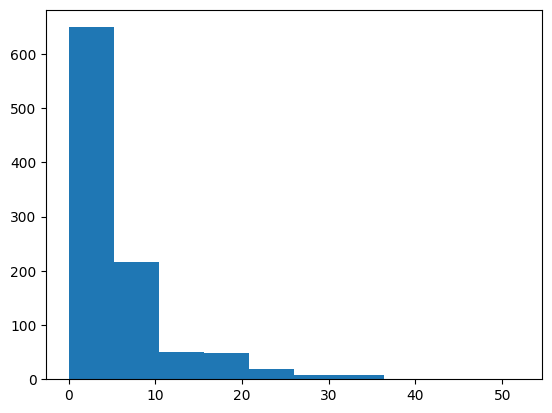

HISTOGRAM "THE LENGTH OF A WORD"


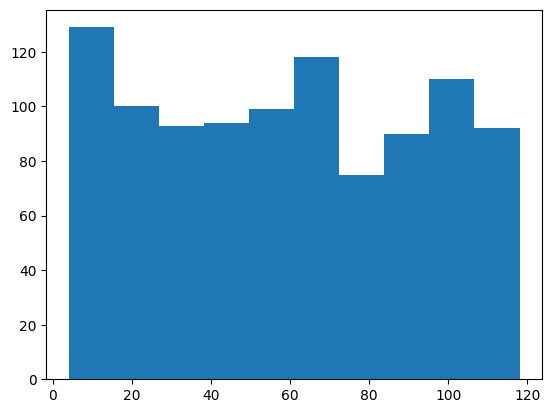

SCATTER PLOT "REDUCTION SIZE OF LENGTH"


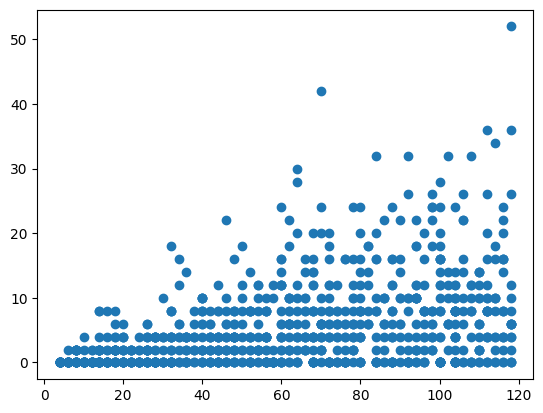

HISTOGRAM "COMMUTATOR DEPTH"


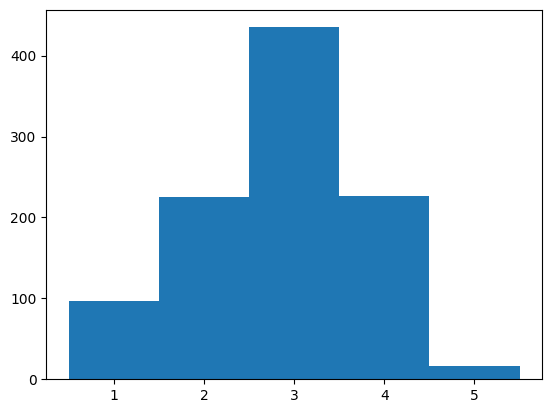

HISTOGRAM "MAX COMMUTEE LENGTH"


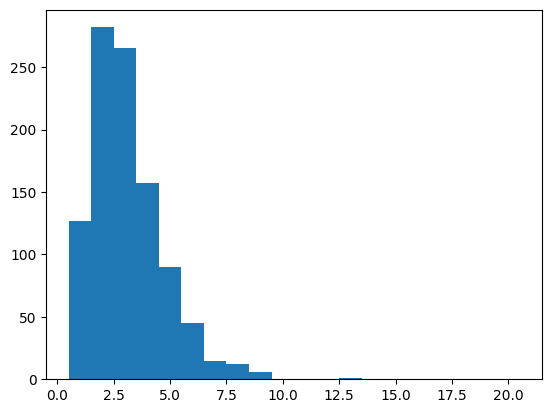

THE RATE OF WORDS CONTAINING MULTIPLICATION: 0.482


In [22]:
from matplotlib import pyplot as plt
from itertools import islice

freegroups = list(map(lambda x: from_tokenizer(x[0]), visualize))
commutators = list(map(lambda x: from_tokenizer(x[1]), visualize))

print('HISTORGRAM "HOW MANY GENERATORS REDUCED"')

diffs = list(map(lambda x: len(to_freegroup(x[1])) - len(x[0]), zip(freegroups, commutators)))
plt.hist(diffs)
plt.show()

print('HISTOGRAM "THE LENGTH OF A WORD"')

lens = list(map(len, freegroups))
plt.hist(lens)
plt.show()

print('SCATTER PLOT "REDUCTION SIZE OF LENGTH"')

plt.scatter(lens, diffs)
plt.show()

print('HISTOGRAM "COMMUTATOR DEPTH"')

from numpy import arange

depths = list(map(calculate_depth, commutators))
plt.hist(depths, arange(1, 5 + 1.5) - 0.5)
plt.show()

print('HISTOGRAM "MAX COMMUTEE LENGTH"')

lengths = list(map(MaxCommuteeLength(), commutators))
plt.hist(lengths, arange(1, 20 + 1.5) - 0.5)
plt.show()

print(f'THE RATE OF WORDS CONTAINING MULTIPLICATION: {sum(map(FindMultiplication(), commutators)) / len(commutators)}')

In [23]:
dataset = list(smp.take_unique(int(2 * 10 ** 5), generator, verbose=True))

100%|██████████| 200000/200000 [08:31<00:00, 391.08it/s]


In [24]:
from pickle import dump

prefix = config.__str__().replace('DatasetConfig', '').replace('(', '').replace(')', '').replace(', ', ';')

with open(path / f'{prefix}.pkl', 'wb') as f:
    dump(dataset, f)

print(prefix)

freegroup_dimension=4;max_commutee_length=3;max_commutator_depth=6;proba_commutator=0.85;proba_multiplication=0.5;max_multipliers_number=3;min_total_length=0;max_total_length=120


# TRAINING

In [3]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(
    tokenizer_file = str(path / 'tokenizer.json'),
    eos_token = eos_token,
    pad_token = pad_token
)

In [4]:
from pickle import load
from sklearn.model_selection import train_test_split

dataset_path = '/home/kibrq/sampling-from-normal-closure/results/commutator-translation/4-free-group/freegroup_dimension=4;max_commutee_length=3;max_commutator_depth=6;proba_commutator=0.85;proba_multiplication=0.5;max_multipliers_number=3;min_total_length=0;max_total_length=120.pkl'

with open(dataset_path, 'rb') as f:
    dataset = load(f)

train_dataset, eval_dataset = train_test_split(dataset, test_size=0.01)

In [5]:
def preprocess(input):
    freegroup_seq, commutator_seq = input
    model_inputs = tokenizer(
        freegroup_seq,
        return_token_type_ids   = False,
        return_attention_mask   = False,
    )
    with tokenizer.as_target_tokenizer():
        model_targets = tokenizer(
            commutator_seq,
        )
    
    model_inputs['input_ids']   = model_inputs['input_ids']
    model_inputs['labels']      = model_targets['input_ids']

    return model_inputs


train_dataset = list(map(preprocess, train_dataset))
eval_dataset = list(map(preprocess, eval_dataset))

In [6]:
from transformers import BertConfig, GPT2Config, EncoderDecoderConfig, EncoderDecoderModel

encoder_config = BertConfig(
    vocab_size              = len(tokenizer),
    hidden_size             = 128,
    max_position_embeddings = 1024,
    num_hidden_layers       = 12,
    num_attention_heads     = 8,
    intermediate_size       = 4 * 128,
    pad_token_id            = tokenizer.pad_token_id,
)

decoder_config = BertConfig(
    vocab_size              = len(tokenizer),
    hidden_size             = 128,
    max_position_embeddings = 1024,
    num_hidden_layers       = 12,
    num_attention_heads     = 8,
    intermediate_size       = 4 * 128,
    pad_token_id            = tokenizer.pad_token_id,
)

config = EncoderDecoderConfig.from_encoder_decoder_configs(
    encoder_config = encoder_config,
    decoder_config = decoder_config,
)

model = EncoderDecoderModel(config=config)
model.config.decoder_start_token_id = tokenizer.eos_token_id
model.config.pad_token_id           = tokenizer.pad_token_id

In [7]:
from evaluate import load, combine

metrics = combine([load("bleu"), load("rouge")])


from re import finditer

def trim_eos_tokens(string):
    positions = finditer(eos_token, string)
    begin = next(positions).end()
    
    try:                    end = next(positions).start()
    except StopIteration:   end = len(string)

    return string[begin:end]


from numpy import argmax

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    labels[labels == -100] = tokenizer.convert_tokens_to_ids(pad_token)

    predictions = tokenizer.batch_decode(logits, skip_special_tokens=False)
    references = tokenizer.batch_decode(labels, skip_special_tokens=False)
    references = list(map(lambda x: eos_token + ' ' +  x, references))
    
    predictions = list(map(trim_eos_tokens, predictions))
    references = list(map(trim_eos_tokens, references))

    print(predictions[0])
    print(references[0])


    return metrics.compute(references = references, predictions = predictions)

In [8]:
from typing import List
import torch

def data_collator(batch: List):
    def max_length_pad(batch: List):
        max_length = max(map(len, batch))
        batch = map(lambda x: x + [tokenizer.pad_token_id] * (max_length - len(x)), batch)
        batch = map(lambda x: torch.tensor(x, dtype=int), batch)
        batch = torch.stack(list(batch))
        
        attention_mask = torch.ones_like(batch)
        attention_mask.masked_fill_(batch == tokenizer.pad_token_id, 0.) 
        return batch, attention_mask
    
    input_ids, attention_mask = max_length_pad([x.input_ids for x in batch])
    labels, decoder_attention_mask = max_length_pad([x.labels for x in batch])
    labels[labels == tokenizer.pad_token_id] = -100
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'decoder_attention_mask': decoder_attention_mask,
    }


In [9]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DefaultDataCollator

prefix = 'bert-bert-long'

args = Seq2SeqTrainingArguments(
    output_dir                  = str(path/prefix),
    overwrite_output_dir        = True,

    predict_with_generate       = True,
    evaluation_strategy         = 'steps',
    eval_steps                  = 500,

    per_device_train_batch_size = 128,
    per_device_eval_batch_size  = 128,
    
    logging_steps               = 1000,
    save_steps                  = 1000,
    
    num_train_epochs            = 200,

    learning_rate               = 8e-5,

    generation_max_length       = 128,
)

trainer = Seq2SeqTrainer(
    model           = model,
    args            = args,
    train_dataset   = train_dataset,
    eval_dataset    = eval_dataset,
    data_collator   = data_collator,
    compute_metrics = compute_metrics,
)

trainer.train('/home/kibrq/sampling-from-normal-closure/results/commutator-translation/4-free-group/bert-bert-long/checkpoint-60000')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading model from /home/kibrq/sampling-from-normal-closure/results/commutator-translation/4-free-group/bert-bert-long/checkpoint-60000.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 198000
  Num Epochs = 200
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 309400
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 38
  Continuing training from global step 60000
  Will skip the first 38 epochs then the first 1214 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1214 [00:00<?, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kibrq. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Bleu,Precisions,Brevity Penalty,Length Ratio,Translation Length,Reference Length,Rouge1,Rouge2,Rougel,Rougelsum
60500,0.130800,0.094176,0.889908,"[0.9864325765235775, 0.925794446034927, 0.8825478718126798, 0.8489306746564728]",0.978468,0.978697,54395,55579,0.977432,0.936652,0.956911,0.956973
61000,0.128900,0.093636,0.887356,"[0.982575591185299, 0.9201687058287104, 0.874733391263133, 0.8399745044822765]",0.982888,0.983033,54636,55579,0.977974,0.935017,0.956214,0.956210
61500,0.128900,0.092590,0.889993,"[0.9800007285709081, 0.9191334921175003, 0.8732073395937291, 0.8380025356836122]",0.987745,0.987819,54902,55579,0.977542,0.934064,0.955335,0.955344
62000,0.127000,0.094460,0.888696,"[0.9856239429369806, 0.9259867165432476, 0.881181046114771, 0.8460823208529631]",0.978487,0.978715,54396,55579,0.977696,0.935425,0.957515,0.957497
62500,0.127000,0.093579,0.889971,"[0.9808053373193095, 0.9192758092283244, 0.8741029119723156, 0.8389037843590741]",0.986961,0.987045,54859,55579,0.978089,0.936080,0.957127,0.957182
63000,0.125000,0.093006,0.892108,"[0.9817620855849277, 0.9219531605275125, 0.8785843705687727, 0.8445752009184845]",0.985447,0.985552,54776,55579,0.977958,0.936852,0.957566,0.957551
63500,0.125000,0.091450,0.893761,"[0.9815074863676982, 0.9224726969886246, 0.8795860956465288, 0.8460467306944075]",0.986487,0.986578,54833,55579,0.978169,0.938747,0.958323,0.958292
64000,0.123000,0.092242,0.891501,"[0.9848251594457884, 0.925253024883951, 0.8811802863697492, 0.8474590231447162]",0.981570,0.981738,54564,55579,0.978724,0.936863,0.957753,0.957768
64500,0.123000,0.091637,0.892537,"[0.9822603876096191, 0.921114874453632, 0.8773427206041416, 0.8431697680607587]",0.986779,0.986866,54849,55579,0.978735,0.936335,0.958048,0.958131
65000,0.121100,0.092690,0.890817,"[0.9797634212920837, 0.9179981114258735, 0.8733267909715408, 0.83926455566905]",0.988618,0.988683,54950,55579,0.977643,0.934812,0.956060,0.956099


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9864325765235775, 0.925794446034927, 0.8825478718126798, 0.8489306746564728]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.982575591185299, 0.9201687058287104, 0.874733391263133, 0.8399745044822765]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-61000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-61000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-61000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9800007285709081, 0.9191334921175003, 0.8732073395937291, 0.8380025356836122]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9856239429369806, 0.9259867165432476, 0.881181046114771, 0.8460823208529631]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-62000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-62000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-62000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9808053373193095, 0.9192758092283244, 0.8741029119723156, 0.8389037843590741]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9817620855849277, 0.9219531605275125, 0.8785843705687727, 0.8445752009184845]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-63000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-63000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-63000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.1

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9815074863676982, 0.9224726969886246, 0.8795860956465288, 0.8460467306944075]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9848251594457884, 0.925253024883951, 0.8811802863697492, 0.8474590231447162]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-64000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-64000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-64000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9822603876096191, 0.921114874453632, 0.8773427206041416, 0.8431697680607587]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9797634212920837, 0.9179981114258735, 0.8733267909715408, 0.83926455566905]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-65000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-65000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-65000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9813513021307594, 0.9208278208278208, 0.8785307405224907, 0.8452463708852995]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9842065772377065, 0.9259540679672511, 0.8842485634737278, 0.8517977920769689]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-66000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-66000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-66000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.1

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9818138660142056, 0.921807190099873, 0.8795280398684184, 0.8467816351221112]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9817643619353895, 0.922602791685632, 0.8799282447563476, 0.8464743063536365]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-67000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-67000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-67000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9827000365363536, 0.924440652256352, 0.8816909735908554, 0.848420188756668]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9826676163863167, 0.9265634181942259, 0.8852678659389592, 0.852542407646709]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-68000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-68000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-68000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9796308779856797, 0.922722029988466, 0.8796942244581131, 0.8464622496778285]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9831296735363851, 0.9249479462426652, 0.8836710603974031, 0.8513004300634855]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-69000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-69000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-69000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.1

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9827126688572472, 0.9247631678666162, 0.883517132729421, 0.8507380073800738]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9820878660325443, 0.9249229372718849, 0.8840975648106292, 0.8518177540457047]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-70000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-70000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-70000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.1

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9817144315612922, 0.923352001816393, 0.8808896405254464, 0.8486039466142635]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.983435717419921, 0.9263131926521937, 0.8853952974593656, 0.8534581895843601]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-71000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-71000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-71000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9840666569215027, 0.9281406463359126, 0.8881682699889607, 0.8575972746675423]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.982590427475338, 0.9271141448615852, 0.8868348443042964, 0.8552318424292162]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-72000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-72000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-72000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9858618416233244, 0.9301383925176793, 0.8901865465180618, 0.8589210764546128]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9833914328995638, 0.9270898448599193, 0.8857868520013388, 0.8539279785206288]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-73000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-73000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-73000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.1

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9853264051522248, 0.9285741415982984, 0.8877132027795326, 0.8552285432423545]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9837643363284388, 0.9278375919326711, 0.8882890692725983, 0.857268848962179]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-74000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-74000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-74000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.98206612774015, 0.92661174514398, 0.8863797030869531, 0.8548156324094514]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9842037983929875, 0.9307619408642911, 0.892297084318361, 0.8622436423297785]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-75000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-75000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-75000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9835599460503773, 0.9276283433586804, 0.8879801832265167, 0.8562190480088405]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9826784574710548, 0.9268048065096035, 0.8867538597698889, 0.8554202067765381]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-76000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-76000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-76000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.1

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9863888175514547, 0.9310279163651598, 0.8913964445500258, 0.8604732654491487]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9843992336465651, 0.9315216362086923, 0.8929436079126071, 0.8625140866714476]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-77000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-77000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-77000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.1

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9832786287381473, 0.9293906131718395, 0.8897521636506688, 0.8587428337428338]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.982123006833713, 0.9281702127659575, 0.8896117936117937, 0.8592736572890025]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-78000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-78000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-78000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9820072480923676, 0.9294853622120164, 0.8918897684193986, 0.8623418045020548]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9780000724874053, 0.925012222180437, 0.8879293501621663, 0.8588101337887846]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-79000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-79000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-79000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9855183763027976, 0.9319415448851774, 0.8933320181495364, 0.8633394947627849]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9829472916286704, 0.9298504637516563, 0.89165846940783, 0.8619291419209503]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/commutator-translation/4-free-group/bert-bert-long/checkpoint-80000
Configuration saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-80000/config.json
Model weights saved in results/commutator-translation/4-free-group/bert-bert-long/checkpoint-80000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.

 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 
 [ [ 2 3, 3 ], [ 2, 4 -1 ] [ 4, 3 ] [ 1 -3, -4 ] [ 3, -2 -1 -2 ] ] 


Trainer is attempting to log a value of "[0.9850103156780048, 0.9316291144757537, 0.8942506549014201, 0.864386623198212]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


KeyboardInterrupt: 

# INFERENCE

In [5]:
from random import randint
from transformers import EncoderDecoderModel, PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(tokenizer_file = '/home/kibrq/sampling-from-normal-closure/results/commutator-translation/4-free-group/tokenizer.json')
model = EncoderDecoderModel.from_pretrained('/home/kibrq/sampling-from-normal-closure/results/commutator-translation/4-free-group/bert-bert-long/checkpoint-60000').to('cuda')

In [6]:
from pickle import load
with open('words.pkl', 'rb') as f: words = load(f)

In [7]:
from torch import tensor
from freegroup import tools, sampling as smp
from itertools import repeat
from re import finditer
from itertools import islice


def sampler(word, **generation_kwargs):
    def sample():
        input_ids = tokenizer(
            to_tokenizer(word),
        ).input_ids
        input_ids = tensor(input_ids, dtype=int, device = model.device)
        outputs = model.generate(input_ids.unsqueeze(0), **generation_kwargs)
        return tokenizer.batch_decode(outputs)

    return sample


from re import finditer

def trim_eos_tokens(string):
    positions = finditer(eos_token, string)
    begin = next(positions).end()
    
    try:                    end = next(positions).start()
    except StopIteration:   end = len(string)

    return string[begin:end]


def translation(
    word,
    num_tries = None,
    **generation_kwargs,
):
    g = smp.iterable_from_batches(sampler(
        word, **generation_kwargs 
    ), num_tries)
    g = map(trim_eos_tokens, g)
    g = map(lambda x: try_or(from_tokenizer, [], x), g)
    
    return filter(lambda x: normalize(to_freegroup(x)) == word, g)


In [8]:
generation_config = dict(
    max_length = 40,
    num_beams = 100,
    num_return_sequences = 50,
)


failed = []

for w in words:
    try: 
        c = next(translation(w, num_tries = 1, **generation_config))
        print(to_lu(c))
    except StopIteration:
        print(w)
        failed.append(w)


[[[Zyz, p], [Z, YXP]], X]
[[[zPZ, Y], [x, yzp]], Z]
[1, 2, 3, -2, -1, -4, -3, -4, -3, -2, 3, 4, 4, -3, 2, 3, -4, 3, 4, 1, 2, -3, -2, -1, -3, -2, 3, -4, -4, -3, 2, 3, 4, 1, -4, -3, -2, 3, 4, 4, -3, 2, 3, 1, 2, 3, -2, -1, -4, -3, 4, -3, -2, 3, -4, -4, -3, 2, 3, 4, 3, 4, 1, 2, -3, -2, -1, -4, -1, 4]
[[[zPZ, Y], [x, yzp]], XZx]
[[Zyz, [P, zpxyZYX]], pYxyP]
[[[y, z], [x, yzp]], P]
[[[y, z], [P, ZYX]], pXP]
[[[xyZYX, Y], [x, yzp]], Xpx]
[1, -4, -1, -4, -3, -2, 3, 4, 1, 2, -1, -2, -1, -4, -3, 2, 3, 4, 1, 1, 4, -1, -1, -4, -3, -2, 3, 4, 1, 2, 1, -2, -1, -4, -3, 2, 3, 4, 1, 3, 3, -1, -4, -3, -2, 3, 4, 1, 2, -1, -2, -1, -4, -3, 2, 3, 4, 1, 1, -4, -1, -1, -4, -3, -2, 3, 4, 1, 2, 1, -2, -1, -4, -3, 2, 3, 4, 1, 4, -3, -3, -1]
[[[PYp, x], [P, ZYX]], Z[y, z]]
[[[xYX, PP], [x, yzp]], z]
[-4, -3, -2, -1, 2, 3, 4, 1, 1, 2, -1, -1, -4, -3, -2, 1, 2, 3, 4, 1, -2, -1, 4, 1, 2, -1, -4, -3, -2, -1, 2, 3, 4, 1, 1, -2, -1, -1, -4, -3, -2, 1, 2, 3, -4, -3, 4, -3, -2, -1, 2, 3, 4, 1, 1, 2, -1, -1, -4, -3, -2, 1,

KeyboardInterrupt: 

In [10]:
word = from_lu('ZYXyzxYXyZYxyzXYxyPZYXyzpxYXyPZYxyzpZYXyzYxyXZYxyzYXyxPZYXyzpYxyXPZYxyzp')

In [75]:
word = failed[0]
to_lu(word), len(word)

('PXYxZYXPXpyzpZYzpZYXPxyXpxzXPxyXpxPYZypXPxYXzpZPxYXpxyzPZyzpZYXzPZxyXpxPYzypXPxYXpxZyzPPZYPxpxyzXyxp',
 100)

wandb: Network error (ReadTimeout), entering retry loop.


PXYxZYXPXpyzpZYzpZYXPxyXpxzXPxyXpxPYZypXPxYXzpZPxYXpxyzPZyzpZYXzPZxyXpxPYzypXPxYXpxZyzPPZYPxpxyzXyxp



In [66]:
assert normalize(to_freegroup(from_lu('[[[xyZY, [Y, z]] [z, Y], [x, yzp]], Xpx]'))) == normalize(word)

In [12]:
generation_config = dict(
    max_length = 40,
    num_beams = 100,
    num_return_sequences = 50,
)

# generation_config = dict(
#     max_length = 40,
#     do_sample = True,
#     temperature = 1.5,
#     num_return_sequences = 100,
# )
s = sampler(word, **generation_config)
s()

['<s> [ [ [ 1, 2 ], [ 1, 2 3 ] ], [ [ 1, 2 ], [ 1, 2 3 4 ] ] ] <s> <s> <s> <s> <s> <s> <s>',
 '<s> [ [ [ 1, 2 ], [ 1, 2 3 ] ], [ [ 1, 2 ], [ 1, 2 3 4 ] ] ] <s> <s> <s> <s> <s> <s> [',
 '<s> [ [ [ 1, 2 ], [ 1, 2 3 ] ], [ [ 1, 2 ], [ 1, 2 3 4 ] ] ] <s> <s> <s> <s> <s> [ [',
 '<s> [ [ [ 1, 2 ], [ 1, 2 3 ] ], [ [ 1, 2 ], [ 1, 2 3 4 ] ] ] <s> <s> <s> <s> [ [ [',
 '<s> [ [ [ 2, 1 ], [ 1, 2 3 ] ], [ [ 1, 2 ], [ 1, 2 3 4 ] ] ] <s> <s> <s> <s> <s> <s> <s>',
 '<s> [ [ [ 1, 2 ], [ 1, 2 3 ] ], [ [ 2, 1 ], [ 1, 2 3 4 ] ] ] <s> <s> <s> <s> <s> <s> <s>',
 '<s> [ [ [ 1, 2 ] [ 1, 2 3 ], [ 2, 3 ] ], [ [ 1, 2 ], [ 1, 2 3 4 ] ] ] <s> <s>',
 '<s> [ [ [ 1, 2 ], [ 1, 2 3 ] ], [ [ 1, 2 3 4 ], [ 1, 2 3 4 ] ] ] <s> <s> <s> <s> <s>',
 '<s> [ [ [ 1, 2 ], [ 1, 2 3 ] ], [ [ 1, 2 ] [ 1, 2 3 4 ], [ 3, 4 ] ] ] <s> <s>',
 '<s> [ [ [ 1, 2 ], [ 1, 2 3 ] ], [ [ 1, 2 ], [ 1, 2 3 4 ] ] ] <s> <s> <s> [ [ [ [',
 '<s> [ [ [ 2, 1 ], [ 1, 2 3 ] ], [ [ 1, 2 ], [ 1, 2 3 4 ] ] ] <s> <s> <s> <s> <s> <s> [',
 '<s> [ [ [ 2, 1 ], [ 1, 

In [51]:
assert normalize(to_freegroup(from_tokenizer('[ -1, [ 2 3 4 -3 -4 -2, [ 2, 3 4 1 ] ] ] '))) == word

In [70]:
from typing import List
from functools import reduce
from random import sample

Word = List[int]

def remove_complementaries(word: Word):
    if len(word) >= 2 and word[-1] == -word[-2]:
        return word[:-2]
    return word

def remove_rotations(word: Word, *substrs: Word):
    for substr in substrs:
        if len(word) < len(substr): continue
        doubled = substr * 2
        for idx in range(len(doubled)):
            if word[-len(substr):] == doubled[idx:idx + len(substr)]:
                return word[:-len(substr)]
    return word

def combine(x, y):
    x.append(y)
    return x

def generate_from_intersection(
    prefix: Word,
    num_generators: int,
    max_iterations: int,
):
    generated = prefix[::]

    stacks = [[] for _ in range(num_generators + 1)]
    bases = [[i] for i in range(1, num_generators + 1)] + [list(range(1, num_generators + 1))]
    ibases = [[-f for f in base[::-1]] for base in bases]

    for i, (base, ibase) in enumerate(zip(bases, ibases)):
        stacks[i] = reduce(lambda x, y: remove_complementaries(remove_rotations(combine(x, y), base, ibase)), prefix, [])

    iteration = 0
    while not all(map(lambda v: len(v) == 0, stacks)) and iteration < max_iterations:
        iteration += 1

        votes = {}
        for stack, base, ibase in zip(stacks, bases, ibases):
            if len(stack) == 0: continue

            last = stack[-1]
            if last == generated[-1]:
                if not last in base and not last in ibase:
                    for key in [base[0], ibase[0]]:
                        votes[key] = votes.get(key, 0) + 1
                elif last in base:
                    idx = base.index(last)
                    key = base[(idx + 1) % len(base)]
                    votes[key] = votes.get(key, 0) + 1
                elif last in ibase:
                    idx = ibase.index(last)
                    key = ibase[(idx + 1) % len(ibase)]
                    votes[key] = votes.get(key, 0) + 1
            else:
                votes[-last] = votes.get(-last, 0) + 1

        max_val  = max(votes.values())
        max_key  = sample([key for key in votes.keys() if votes[key] == max_val], k = 1)[0]

        generated.append(max_key)
        
        for i, (base, ibase) in enumerate(zip(bases, ibases)):
            stacks[i] = remove_complementaries(remove_rotations(combine(stacks[i], max_key), base, ibase))
    
    
    if not all(map(lambda v: len(v) == 0, stacks)):
        return None
    
    return generated   

In [71]:
from numpy.random import randint
from tqdm import trange

number_generators = 4
max_prefix_length = 20

tries = 200
max_iterations = 150

num_samples = 20

unique = set()

for _ in trange(num_samples):
    
    generated = None
    while generated is None or tuple(generated) in unique:
        prefix = None
        while prefix is None or len(prefix) == 0:
            prefix = randint(-number_generators, number_generators + 1, size = randint(max_prefix_length)).tolist()
            prefix = [f for f in prefix if f != 0]
            prefix = reduce(lambda x, y: remove_complementaries(combine(x, y)), prefix, [])
        
        iteration = 0
        while generated is None and iteration < tries:
            generated = generate_from_intersection(prefix, number_generators, max_iterations)
            iteration += 1
    unique.add(tuple(generated))

100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


In [74]:
generation_config = dict(
    max_length = 40,
    num_beams = 100,
    num_return_sequences = 50,
)


failed = []

for w in unique:
    w = list(w)
    try: 
        c = next(translation(w, num_tries = 1, **generation_config))
        print(to_lu(c))
    except StopIteration:
        print(w)
        failed.append(w)
    

[-4, -1, -2, 1, -3, -2, -1, -4, -1, 4, 2, 3, 4, -3, -2, 3, 4, -3, -2, -1, -4, 1, 2, -1, 4, 1, 3, -1, -4, 1, 2, -1, 4, 1, -4, -2, -3, 2, 4, -1, -4, 1, -2, -1, 3, 4, -3, -4, 1, -2, -1, 4, 1, 2, 3, -4, -3, 2, 3, 4, -3, -2, -1, 3, -4, -3, 1, 2, -1, 4, 1, -4, -2, 3, 2, 4, -1, -4, 1, -2, -1, 4, 1, -3, 2, 3, -4, -4, -3, -2, -4, 1, 4, 1, 2, 3, -1, 2, 1, 4]
[4, 1, 3, -2, 3, 1, 3, 4, -1, -4, -4, -1, 2, -3, -2, -1, 2, 3, -2, 4, -3, -2, -1, -4, 1, 2, 3, 2, -3, -2, 1, 2, 3, -2, -3, -1, -2, -1, 4, 1, 2, 3, -4, -3, 1, 3, 1, 4, 4, 1, -4, -3, -1, -3, 2, -3, -1, -4]
[[[Y, Z], x], [pxy, xP][P, Zx][x, y]]
[-1, -4, 1, 2, -1, -4, -3, -2, 3, 4, 4, 1, -4, -3, 4, -1, -4, 1, 3, -1, -4, -3, 2, 3, 4, 1, -2, -3, -1, 4, 1, -4, 3, 4]
[1, 2, 3, 4, -3, -2, -1, 2, 3, -2, 1, 2, -4, -2, -1, 2, -3, -2, 3, 1, 4, -1, -3, 1, 3, -4, -3, -1, -4, -3, -2, 3, 4, -3, -1, 3, 1, -4, -1, -3, 2, 3, -2, 1, 2, 4, -2, -1, 2, -3, -2, 1, 2, 3]
[[X, [pYP, [P, z]]], [X, z][z, yzp]]
[1, 2, 3, -2, -1, -4, -3, 4, -2, -1, 2, 3, -2, -1, -4, -3, 4